# 객담도말 결핵진단 딥러닝 모델 테스트

훈련된 딥러닝 모델을 테스트하는 코드입니다. 훈련된 딥러닝 모델의 architecture와 weights 정보가 담겨있는 파일을 로딩하여, 딥러닝 모델을 재구성합니다.

In [1]:
# import

%matplotlib notebook

import os
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.utils import np_utils

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

Using Theano backend.


In [13]:
# configuraiton
MODEL_NAME = 'tb_cnn'
#MODEL_NAME = 'tb_vgglike'

MODEL_ARCHITECUTRE_FILE_PATH = './save/' + MODEL_NAME + '_model_architecture.json'
MODEL_WEIGHTS_FILE_PATH = './save/' + MODEL_NAME + '_model_weights.h5'

TEST_IMAGE_FILE_PATH = './dataset/test_image_64x64_gray_15873.bin'
TEST_LABEL_FILE_PATH = './dataset/test_label_64x64_gray_15873.bin'
TEST_RESULT_FILE_PATH = './output/' + MODEL_NAME + '_test_result.txt'

IMG_CHANNELS = 1
IMG_ROWS = 64
IMG_COLS = 64

NUM_CLASSES = 2

TEST_DATA_COUNT = 15873

In [3]:
# 입력된 경로를 검사하여 폴더가 없다면 생성합니다.

def check_make_dir(path):
    
    dirname = os.path.dirname(path)
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [4]:
# architecture와 weight가 저장된 파일로부터 모델을 로딩합니다.

def load_model(model_architecture_file_path, model_weights_file_path):
    
    fp_json = open(model_architecture_file_path, 'r')
    json_string = fp_json.read()
    fp_json.close()
        
    model = model_from_json(json_string)
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

    model.load_weights(model_weights_file_path)
    model.summary()
    
    return model

In [5]:
# 이미지 자료를 파일로부터 로딩합니다.

def load_image(filename, count, channel, row, col):
    print('Loading data from', filename)

    print('file size : ', os.path.getsize(filename))
    print('calc size : ', count * channel * row * col)
    
    fp = open(filename, 'rb')
    buf = fp.read(count * channel * row * col)
    data = np.frombuffer(buf, dtype=np.uint8)
    data = data.reshape(count, channel, row, col)

    print('loaded shape : ', data.shape)

    data = data.astype('float32')
    data /= 255

    return data

# 라벨 자료를 파일로부터 로딩합니다.

def load_label(filename, count, classes):
    print('Loading labels from ', filename)
    
    print('file size : ', os.path.getsize(filename))
    print('calc size : ', count)
    
    fp = open(filename, 'r')
    buf = fp.read(count)
        
    data_bin = []
    for i in buf:
        data_bin.append(i)
    data = np.asarray(data_bin, dtype=np.uint8, order='C')

    print('loaded shape : ', data.shape)
    
    label_hist = np.histogram(data, bins=range(NUM_CLASSES+1))
    print(label_hist)
    
    # convert class vectors to binary class matrices
    data = np_utils.to_categorical(data, classes)

    return data

In [6]:
# 잘 못 분류된 샘플을 표출한다. test_image, classes, test_classes):   
def ShowSample(sample_list):

    plt.figure(figsize=(10, 10))
    
    for ind, val in enumerate(sample_list[:100]):
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(10, 10, ind + 1)
        patch_image = val[0].reshape((IMG_ROWS,IMG_COLS))
        plt.axis("off")
        plt.text(0, 0, 'T%d'%val[2], fontsize=14, color='blue')
        plt.text(20, 0, 'R%d'%val[1], fontsize=14, color='red')
        plt.imshow(patch_image, cmap='gray')

In [9]:
# 테스트셋을 로딩합니다.

test_image = load_image(TEST_IMAGE_FILE_PATH,
                        TEST_DATA_COUNT, 
                        IMG_CHANNELS, 
                        IMG_ROWS, 
                        IMG_COLS)

test_label = load_label(TEST_LABEL_FILE_PATH,
                        TEST_DATA_COUNT, 
                        NUM_CLASSES)

('Loading data from', './dataset/test_image_64x64_gray_15873.bin')
('file size : ', 65015808)
('calc size : ', 65015808)
('loaded shape : ', (15873, 1, 64, 64))
('Loading labels from ', './dataset/test_label_64x64_gray_15873.bin')
('file size : ', 15873)
('calc size : ', 15873)
('loaded shape : ', (15873,))
(array([15520,   353]), array([0, 1, 2]))


In [14]:
# 모델을 로딩합니다.
    
model = load_model(MODEL_ARCHITECUTRE_FILE_PATH, 
                   MODEL_WEIGHTS_FILE_PATH)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 32, 62, 62)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 32, 62, 62)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 32, 60, 60)  9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)          (None, 32, 60, 60)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

15873/15873 [==============================] - 37s    


<IPython.core.display.Javascript object>


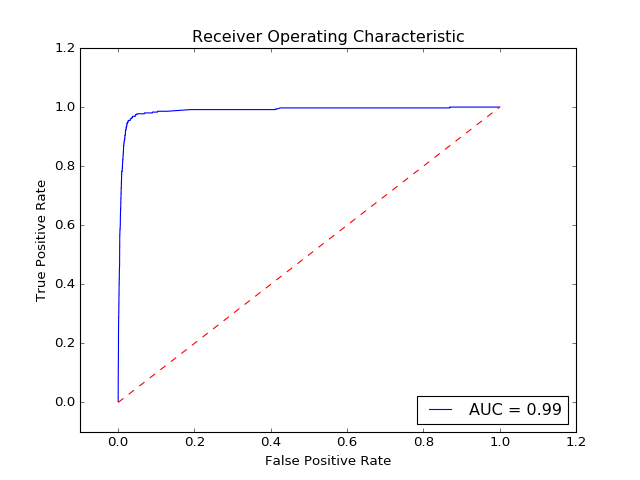

In [15]:
# ROC AUC 

test_classes = np_utils.categorical_probas_to_classes(test_label) # [1 0]을 0으로, [0 1]을 1로 즉 one-hot을 클래스로 
probas = model.predict_proba(test_image, batch_size=32)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_classes, probas[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
false_positive_rate.shape

(2334,)

In [18]:
true_positive_rate.shape

(2334,)

In [19]:
thresholds.shape

(2334,)

In [20]:
thresholds

array([  9.99995828e-01,   9.99961615e-01,   9.99960244e-01, ...,
         4.57945305e-07,   3.32997473e-07,   2.19762546e-28])

In [22]:
probas[:,1].shape

(15873,)

In [29]:
# 음성 15520
# 양성 353

count = 0

for i in range(len(test_classes)):
    if test_classes[i] == 1:
        count = count + 1
        
print(count)

353


In [ ]:
# 모델을 평가합니다.

score = model.evaluate(test_image, test_label, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

classes = model.predict_classes(test_image, batch_size=32)
np.savetxt(TEST_RESULT_FILE_PATH, classes, fmt='%d')

print(TEST_RESULT_FILE_PATH + ' is saved.')

In [ ]:
true_sample_list = []
false_sample_list = []
wrong_sample_list = []

for im in zip(test_image, classes, test_classes):
    if im[1] != im[2]:
        wrong_sample_list.append(im)
    else:
        if im[1] == 1:
            true_sample_list.append(im)
        else:
            false_sample_list.append(im)

In [ ]:
print('True Sample')
ShowSample(true_sample_list)

In [ ]:
print('False Sample')
ShowSample(false_sample_list)

In [ ]:
print('Wrong Sample')
ShowSample(wrong_sample_list)